# Plot NA 43 conservation, NA variant activity, surface expression, and viral titers

## Globals

In [1]:
import matplotlib
matplotlib.use("svg")
from IPython.display import Image, display
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import numpy as np
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
import Bio.SeqIO
import re


matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('font', size=8)
matplotlib.rc('xtick', labelsize=6)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=6)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=8)

#matplotlib.rcParams('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
matplotlib.rc('axes', linewidth=.6)
matplotlib.rc('xtick.major', width=.6)
matplotlib.rc('xtick.major', size=2.5)
matplotlib.rc('ytick.major', width=.6)

matplotlib.rc('ytick.major', size=2.5)

## NA 43 conservation 



Here we are looking at the distribution of codons at coding nucleotides 43-45 of influenza N1 NA in several influenza host lineages.

The input data are in ../data/N1seq/, and consist of:

* fluNAs.fasta: all full-length N1 NA protein-coding sequences as downloaded from the Influenza Virus Resource on Aug-22-2017.

* WSN-NA.fasta: the protein coding sequence of the A/WSN/1933 (H1N1) influenza NA used in Heather's ribosome profiling experiment

### Align NA sequences and define viral lineages

We build this alignment from all N1 NA sequences (downloaded from the Influenza Virus Resource) plus the WSN NA from the Bloom lab reverse genetics plasmid that was used in Heather's ribosome profiling.

We use phydms_prepalignment to construct a codon-level alignment that is subsampled such that all sequences have at least 2 amino-acid differences relative to other sequences. This is to avoid having the alignment be completely dominated by a bunch of highly similar sequences that are heavily represented in the database.

The sequences are trimmed relative to A/WSN/1933, so all numbering is 1, 2, 3, ... in reference to that sequence. All nucleotide numbering is relative to the coding sequence, so 1 refers to the first nucleotide of the initiating ATG codon.


In [2]:
# put results in this directory
resultsdir = '../data/N1seq/'
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)
    
# concatenate all reference sequence and all others into one file
allseqs = os.path.join(resultsdir, 'allseqs.fasta')
!cat ../data/N1seq/WSN-NA.fasta ../data/N1seq/fluNAs.fasta > {allseqs}

# run phdyms_prepalignment
alignment = os.path.join(resultsdir, 'alignment.fasta')
!phydms_prepalignment {allseqs} {alignment} WSN-NA --minidentity 0.7 --minuniqueness 2


Beginning execution of phydms_prepalignment in directory /fh/fast/subramaniam_a/user/hmachkov/git/2018_hmachkov_paper/scripts at time Tue May 15 13:14:14 2018

Version information:
	Time and date: Tue May 15 13:14:14 2018
	Platform: Linux-3.13.0-143-generic-x86_64-with-Ubuntu-14.04-trusty
	Python version: 2.7.6 (default, Jun 22 2015, 17:58:13)  [GCC 4.8.2]
	phydms version: 2.2.0
	Bio version: 1.70
	cython version: 0.27.3
	numpy version: 1.13.3
	scipy version: 1.0.0
	matplotlib version: 2.1.1
	natsort version: 5.1.1
	sympy version: 1.1.1
	six version: 1.11.0
	pandas version: 0.22.0
	pyvolve version: 0.8.7
	statsmodels version: 0.8.0
	weblogolib version: 3.5.0
	PyPDF2 version: 1.26.0

Parsed the following command-line arguments:
	inseqs = ../data/N1seq/allseqs.fasta
	minidentity = 0.7
	prealigned = False
	purgeseqs = None
	minuniqueness = 2
	keepseqs = None
	refseq = WSN-NA
	alignment = ../data/N1seq/alignment.fasta
	mafft = mafft

Read 22451 sequences from ../data/N1seq/allseqs.fasta
R

Now we read the alignment into a pandas DataFrame, annotating the viral lineage and year of isolation. We make these annotations taking advantage of the fact that the last three items in the FASTA headers are subtype, host, and year.

We annotate into common lineages as follows. These annotations might not get all the phylogenetic outliers since they are just grouping by year and host, but should be close to fully correct:

seasonal H1N1: Human H1N1 from before 2009, this should mostly be human seasonal H1N1.
pdmH1N1: Human H1N1 from after 2009, this should mostly be human pandemic H1N1.
Avian: Any avian strain.
Swine: any swine strain.
other anything else. We exclude these from subsequent analyses.
There are a few known sequences indicates as Human that aren't either seasonal H1N1 or pandemic H1N1. These can be mis-annotated sequences from other hosts or (more often) zoonotic infections of humans with some non-human strain. So we exclude these below:

We manually exclude A/Maryland/12/1991, which is a swine zoonotic sequence, from seasonal H1N1.
For pdmH1N1, we get the pairwise distance of everything to a known pdmH1N1 sequence (A/California/04/2009), and then exclude the sequences with extreme distances ( 50 nucleotides Hamming distance from A/California/04/2009 ).

In [2]:
# read alignment into pandas DataFrame
resultsdir='../data/N1seq/'

d = dict([(key, []) for key in ['strain', 'seq', 'host', 'year', 'subtype', 'lineage']])
for seq in Bio.SeqIO.parse(os.path.join(resultsdir, 'alignment.fasta'), 'fasta'):
    strain = seq.name
    (subtype, host, year) = strain.split('_')[-3 : ]
    if year.lower() == 'unknown' or not host:
        continue
    year = int(year)
    d['strain'].append(strain)
    d['host'].append(host)
    d['year'].append(year)
    d['subtype'].append(subtype)
    d['seq'].append(str(seq.seq).upper())
    if host == 'Human' and subtype == 'H1N1':
        if 1918 <= year <= 1957 or 1977 <= year < 2009:
            if 'A/Maryland/12/1991' in strain:
                d['lineage'].append('other') # this is a zoonotic swine strain
            else:
                d['lineage'].append('seasonal H1N1')
        else:
            d['lineage'].append('pdmH1N1')
    elif host == 'Avian':
        d['lineage'].append('avian')
    elif host == 'Swine':
        d['lineage'].append('swine')
    else:
        d['lineage'].append('other')
df = pd.DataFrame(d)

# some further parsing to pdmH1N1 sequences are actually close to known pdmH1N1 sequence
ca09 = df[df['strain'].str.contains("A/California/04/2009")]
assert len(ca09) == 1, "Didn't find just one A/California/04/2009"
ca09seq = ca09['seq'].values[0]

def hammingDistance(s1, s2):
    """Returns Hamming distance between two seqs."""
    assert len(s1) == len(s2)
    return sum([x != y for (x, y) in zip(s1, s2)])

df['distance_from_Cal09'] = [hammingDistance(ca09seq, s) for s in df['seq'].values]


pdmH1N1cutoff = 50
print("Filtering all pdmH1N1 sequences with Hamming distance from Cal09 > {0}".format(pdmH1N1cutoff))
df.loc[(df['lineage'] == "pdmH1N1") & (df['distance_from_Cal09'] > pdmH1N1cutoff), 'lineage'] = 'other'


### subsample seasonalH1N1 to 1 sequence per year
sub = df[df['lineage'] == 'seasonal H1N1'].reset_index()
sub=sub.sample(frac=1, random_state=1)
sub=sub.groupby('year').nth([0,1]).reset_index(drop=False, inplace=False)

#sub=sub.drop_duplicates(subset='year', keep="first")
df = df[df['lineage'] != 'seasonal H1N1'].reset_index()
df=pd.concat([df,sub])

nperlineage = df.groupby('lineage').size().sort_values(ascending=False)
print("Here are the number of sequences per lineage:\n{0}\n".format(nperlineage))

print("Ignoring lineage 'other' for all subsequent analyses.")
df = df[df['lineage'] != 'other'].reset_index()


Filtering all pdmH1N1 sequences with Hamming distance from Cal09 > 50
Here are the number of sequences per lineage:
lineage
avian            1530
swine            1514
pdmH1N1          1381
other             270
seasonal H1N1      77
dtype: int64

Ignoring lineage 'other' for all subsequent analyses.


In [4]:
hosts=['avian','swine','seasonal H1N1','pdmH1N1']
for host in hosts:
    lineagegroup=df[df['lineage'] == host]
    f=open('../data/N1seq/S3_file_N1_seq_%s.fasta'%host,'wb')
    for index, row in lineagegroup.iterrows():
        f.write('>')
        f.write(row['strain'])
        f.write('\n')
        f.write(row['seq'])
        f.write('\n')
        
    f.close()

## Plot codon identity at coding nucleotide position 43 in N1 lineages defined above

### Fig 4c



/home/hmachkov/venv/hm_py2/local/lib/python2.7/site-packages/matplotlib/tight_layout.py:222: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


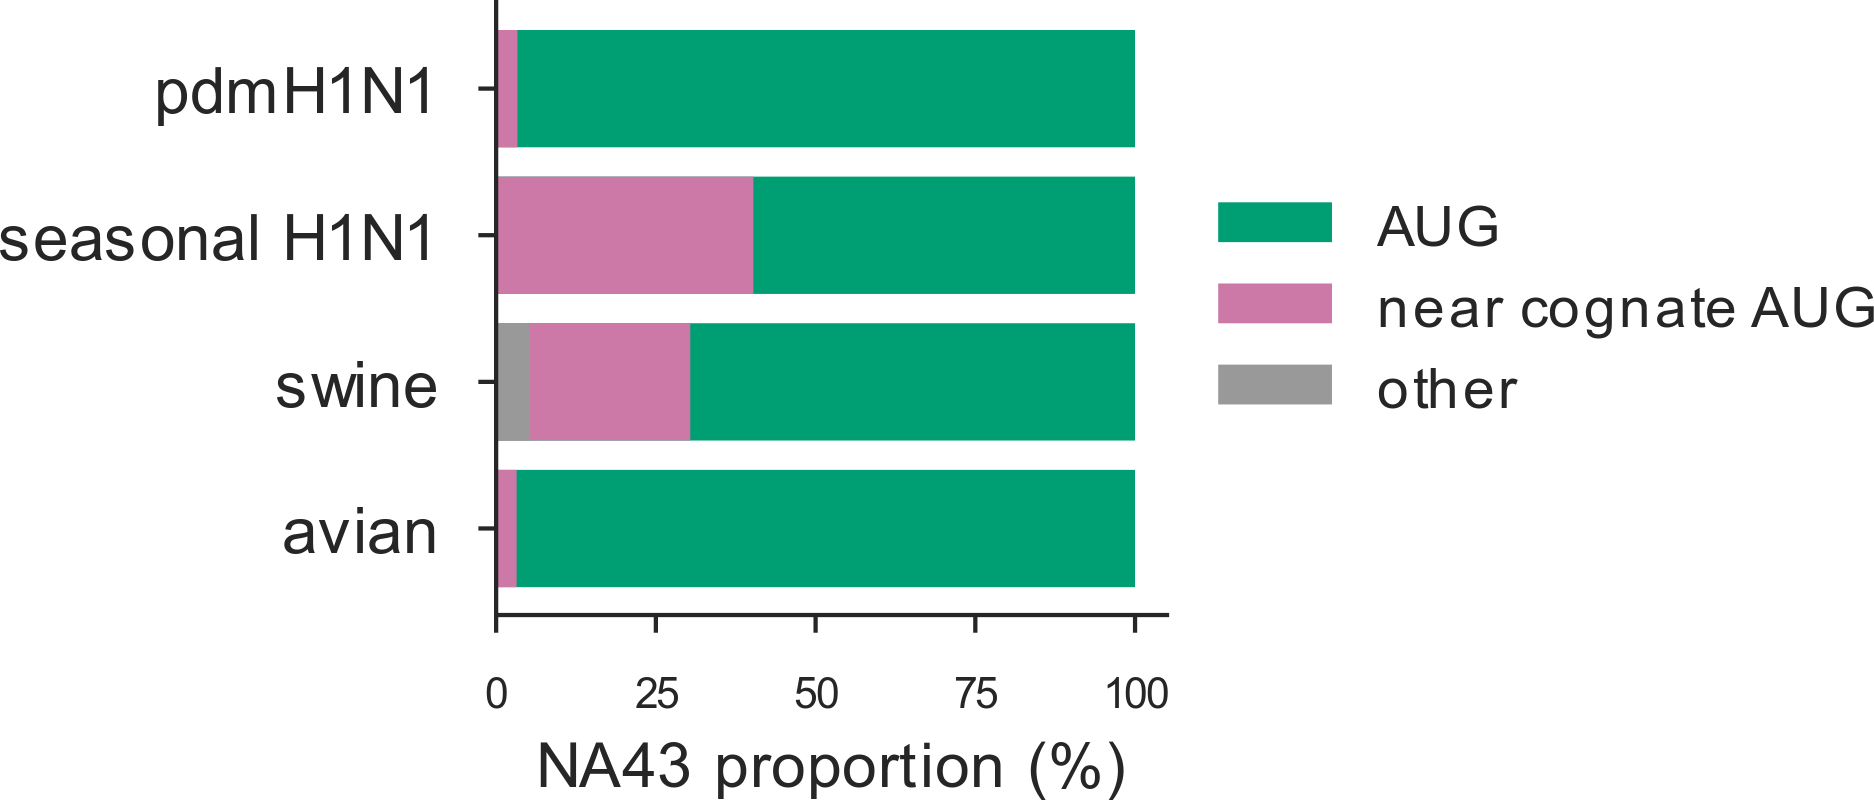

In [5]:
lintype=['avian','swine','seasonal H1N1','pdmH1N1']
start_sites=['CTG','GTG','TTG','ACG','AGG','ATC','ATT','AAG','ATA']
matplotlib.rc('ytick', labelsize=9)

lin_43_counts={}
for lin in lintype:
    seasonal=df[df['lineage']==lin]
    counts_43={'ATG':0,'total':0,'near cognate ATG':0,'other':0,'CTG':0,'GTG':0,'TTG':0,'ACG':0,'AGG':0,'ATC':0,'ATT':0,'AAG':0,'ATA':0}
    counts_43['other']=0
    seasonal_names=seasonal.index.tolist()
    for strain in seasonal_names:
        seq=df.loc[strain]['seq']
        codon=seq[42:45]
        if codon in start_sites:
            counts_43['near cognate ATG']+=1#+=1
        elif codon=='ATG':
            counts_43[codon]+=1
        else:
            #print codon
            counts_43['other']+=1
        counts_43["total"]+=1
    lin_43_counts[lin]=counts_43

legend=['ATG','near cognate ATG','other']
legend=legend[::-1]
colors=['#999999','#CC79A7','#009E73']
colors=colors[::-1]
fig = plt.figure()
samples = lintype
plot_data=[[],[],[]]
for j,sample in enumerate(samples):
    sampletot=0
    for n,o in enumerate(legend):
        plot_data[n].append(100*float(lin_43_counts[sample][o])/lin_43_counts[sample]['total']+sampletot)
        sampletot+=100*float(lin_43_counts[sample][o])/lin_43_counts[sample]['total']
plot_data=plot_data[::-1]
legend=legend[::-1]
N=4
i=0
ind = np.arange(N)  # the x locations for the groups
#width = .8       # the width of the bars
ax = fig.add_subplot(1,1,1)
Ulegend=['AUG','near cognate AUG','other']
for index,data in enumerate(plot_data):
    ax.barh(ind, data, color=colors[index],align='center',label=Ulegend[index],linewidth=0)
ax.set_xlabel('NA43 proportion (%)') 

matplotlib.rc('ytick', labelsize=9)

ax.set_yticks(ind)
ax.set_yticklabels(samples)

ax.legend()
sns.despine()

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.set(size_inches=(5,2))

fig.tight_layout(pad=2)
plt.subplots_adjust(right=0.5)

filepath = '../figures/codoncounts_NA_43_subsampled_proportion.svg' 
plt.savefig(filepath)
png = filepath.rstrip('.svg') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=250))
sys.stdout.flush()

## Plot titers for NA 43 variants



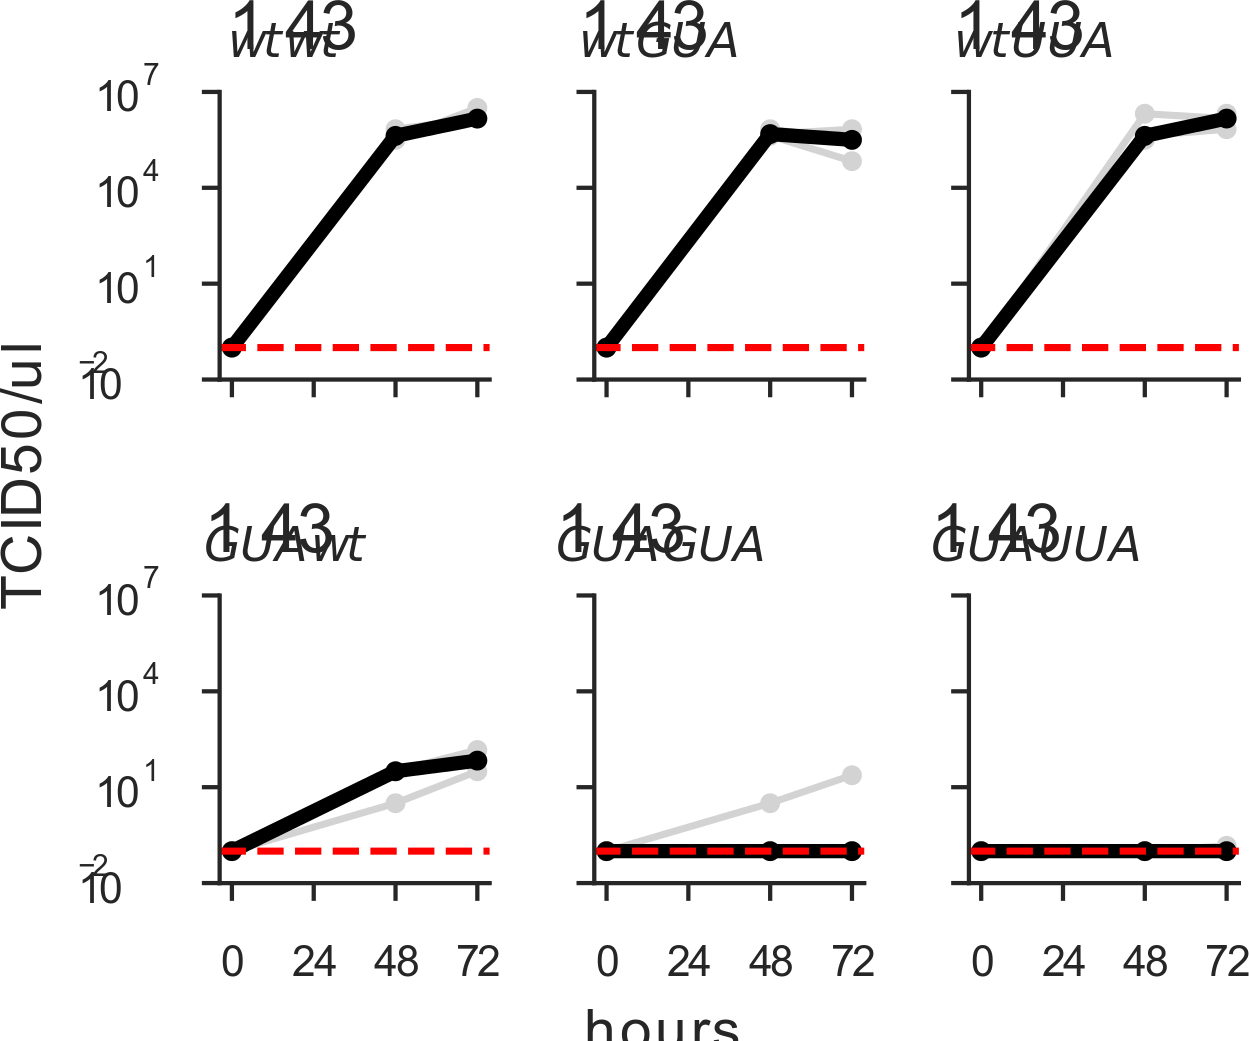

In [6]:
 
titer_list=[]
file_dir='../data/NA43_activity_expression_titers/'
titer_files=['20171114_RG_viraltiters_72hr','20171113_RG_viraltiters_48hr']
plot_order = ["1ATG_43ATG","1ATG_43GTA","1ATG_43TTA","1GTA_43ATG","1GTA_43GTA","1GTA_43TTA"]
assay_name='tcid50/ul'
matplotlib.rc('xtick', labelsize=6)    # fontsize of the tick labels

for titer_file in titer_files:
    ###  adjust dataframe
    timepoint_titer=pd.read_csv('%s/%s.csv'%(file_dir,titer_file) , sep = ',', index_col = None)
    timepoint_titer[4]= timepoint_titer.median(axis=1)

    timepoint_titer_df=pd.melt(timepoint_titer, id_vars='NA variant', value_vars=["1","2","3",4], var_name='replicate', value_name=titer_file[-4:-2])
    titer_list.append(timepoint_titer_df)

titer_df=pd.merge(titer_list[0],titer_list[1], on=['NA variant', 'replicate'])
titer_df['0']=.1

titer_df_long=pd.melt(titer_df, id_vars=['NA variant','replicate'], value_vars=["72","48","0"], var_name='time',value_name=assay_name)
titer_df_long['time'] = titer_df_long['time'].apply(pd.to_numeric)
fig, ax = matplotlib.pyplot.subplots()
d = {'color': ['lightgray', 'lightgray','lightgray','black'], "linewidth" : [1,1,1,2]}
matplotlib.rc('ytick', labelsize=6)    # fontsize of the tick labels

g = sns.FacetGrid(titer_df_long, col="NA variant", col_order=plot_order,hue="replicate",hue_order=['1','2','3',4],hue_kws=d,col_wrap=3,)
g = (g.map(plt.plot, "time", assay_name, marker=".").set_titles("").set_ylabels('').set_xlabels('').set(ylim=(.01,10000000),yticks=[.01, 1,100, 10000,100000,10000000],xticks=[0, 24,48, 72]))

titles = ["1$_{wt}$ 43$_{wt}$",r'1$_{wt}$ 43$_{GUA}$',r'1$_{wt}$ 43$_{UUA}$',r'1$_{GUA}$ 43$_{wt}$',r'1$_{GUA}$ 43$_{GUA}$',r'1$_{GUA}$ 43$_{UUA}$']
i=0
for ax in g.axes.ravel():
    ax.set_yticks([.01, 1,100, 10000,100000,10000000])
    ax.set_yticklabels([.01, 1,100, 10000,100000,10000000])
    ax.axhline(y=.1, color='red',linewidth=1,linestyle='--')
    ax.set_title(titles[i])
    #ax.axhline(linewidth=4, color='r')
    i+=1
plt.yscale('log')

g.fig.text(0.5, 0.0, 'hours', ha='center')
g.fig.text(0.0, 0.5, 'TCID50/ul', va='center', rotation='vertical')

g.fig.set_size_inches([2.6, 2.2])
g.fig.tight_layout(pad=1.3)

filepath = '../figures/rg_viraltiters.svg' 
plt.savefig(filepath)
png = filepath.rstrip('.svg') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=400))
sys.stdout.flush()
    


## Plot NA surface expression and NA activity

### NA surface expression

Below we are plotting NA surfacce expression from cells transfected with various NA - V5 - IRES - GFP constructs. The relative NA surface expression is calculated by taking the mean fluorescence intensity from anti-V5 staining and subtracting off the background staining from NA - IRES - GFP (lacking V5 tag), normalizing expression to WT (ATG | ATG), and plotting the mean NA expression along with the values from each replicate.

### Plot NA activity

Below we are plotting relative NA acivity measured using a MUNANA assay. Cells were transfeced with various NA - V5 - IRES - GFP constructs. The relative NA activity is calculated by taking the raw fluorescence value from MUNANA assay, subtracting background (fluorescence from untreated cells), correcting for transfection efficiency of constructs (% GFP positive), and normalizing activity to WT (ATG | ATG). The mean NA activity along with the values from each replicate is plotted.



In [7]:
####### calculations and dataframe
def df_na_activity_facet(file_dir,na_files,plot_order,wt,control,assay_name):
    na_df_list=[]
    titles=[]
    for i,na_file in enumerate(na_files):
        na=pd.read_csv('%s/%s.csv'%(file_dir,na_file) , sep = ',', index_col = None) 
        na_df=pd.melt(na, id_vars='NA variant', value_vars=["1","2","3"], var_name='replicate', value_name=assay_name)
        ###  adjust dataframe from long to wide
        trans_eff=pd.read_csv('%s/%s.csv'%(file_dir,transfectioneff_files[i]) , sep = ',', index_col = None)   
     
        trans_eff_df=pd.melt(trans_eff, id_vars='NA variant', value_vars=["1","2","3"], var_name='replicate', value_name="transfection efficiency")
        ### correct for TE, background
        na_df=na_df.merge(trans_eff_df,how='left', left_on=['NA variant','replicate'], right_on=['NA variant','replicate'])
        untrval=na_df[na_df['NA variant']==control][assay_name].values[0]
        na_df['background subtracted']=na_df[assay_name]-untrval
        na_df['TE corrected']=na_df['background subtracted']/na_df['transfection efficiency']
        fullactivity=na_df[na_df['NA variant']==wt]['background subtracted'].mean()
        na_df["{0}".format(assay_name)]=na_df['background subtracted']/fullactivity
        title=na_file.split('_')[-1]
        na_df['NAtype']=title
        na_df_list.append(na_df)
        titles.append(title)
         
    ###### combine  df        
    na_df2=pd.concat(na_df_list, axis=0)
    na_df2 = na_df2.dropna(axis=0)
    na_df2['assayvalue']=na_df2["NA activity"]
    na_df2['assay']="NA activity"
    #na_df.at['C', 'x'] = 10
    return na_df2



In [8]:
## plotting function for faceted NA
def df_na_expression_facet(file_dir,na_files,plot_order,wt,control,assay_name):
    na_df_list=[]
    titles=[]
    for i,na_file in enumerate(na_files):
        ###  adjust dataframe from long to wide
        na=pd.read_csv('%s/%s.csv'%(file_dir,na_file) , sep = ',', index_col = None)   
        na_df=pd.melt(na, id_vars='NA variant', value_vars=["1","2","3"], var_name='replicate', value_name=assay_name)

        ## subtract background from NA-GFP control 
        background=na_df.loc[(na_df['NA variant']==control) & (na_df["replicate"] == '1')][assay_name].values[0]
        na_df["background subtracted {0}".format(assay_name)]=na_df[assay_name]- background

        ## normalize to be relative activity to WT
        fullactivity=na_df[na_df['NA variant']==wt]["background subtracted {0}".format(assay_name)].mean()
        na_df["NA expression"]=na_df["background subtracted {0}".format(assay_name)]/fullactivity
        title=na_file.split('_')[-1]
        na_df['NAtype']=title
        na_df_list.append(na_df)
        titles.append(title)
         
    ###### combine  df        
    na_df2=pd.concat(na_df_list, axis=0)
    na_df2 = na_df2.dropna(axis=0)
    na_df2['assayvalue']=na_df2["NA expression"]
    na_df2['assay']="NA expression"

    return na_df2


In [9]:
## plotting input and parameter info
matplotlib.rc('ytick.major', width=1)
matplotlib.rc('xtick', labelsize=9)
matplotlib.rc('ytick.major', size=4)
matplotlib.rc('ytick.minor', size=2.5)
na={}
file_dir='../data/NA43_activity_expression_titers/'
na_files=['20170927_293t_NAsurfaceexpression_wsn','20170928_293t_NAsurfaceexpression_ca09']

wt='1ATG_43ATG'
control='no NA'
assay_name='NA surface expression'
exp=df_na_expression_facet(file_dir,na_files,plot_order,wt,control,assay_name)

na_files=['20170927_293t_munana_lowcells_wsn','20170928_293t_munana_lowcells_ca09']
transfectioneff_files=['20170927_293t_transfectionefficiency_wsn','20170928_293t_transfectionefficiency_ca09']
plot_order = ["1ATG_43ATG","1ATG_43GTA","1GTA_43ATG","1GTA_43GTA"]
wt="1ATG_43ATG"
control='untr'
assay_name='NA activity'

act=df_na_activity_facet(file_dir,na_files,plot_order,wt,control,assay_name)


In [10]:
concat_df=pd.concat([act,exp], axis=0)

In [13]:
#plotting viral strain
def plot_viral_strain(file_dir,outfile,plot_order,xticklab,df,strain,fig_size,aspect,size):
    subsetdf=df.loc[df['NAtype']==strain]  

    fig, ax = matplotlib.pyplot.subplots()
    g = sns.factorplot(x="NA variant", y="assayvalue",hue="assay",size=size, aspect=aspect,hue_order=['NA expression','NA activity'],row="assay",order=plot_order,data=subsetdf, kind="swarm",sharey=True,row_order=['NA expression','NA activity'],s=3.5)
    g.set_titles("").set_ylabels("").set_xlabels('')
    median_width = .8
    i=0
    titles=['NA expression','NA activity']
    for axax in g.axes.ravel():
        axax.plot([.8], [.8],lw=2, color='k')
        
        title=titles[i] 
        axax.set_ylabel(title)
        mean_vals=[]
        for sample_name in plot_order:
            tick=axax.get_xticks()
            mean_val=subsetdf[(subsetdf['NA variant']==sample_name) &(subsetdf['assay']==title)]["assayvalue"].mean()
         
            mean_vals.append(mean_val)
            
        axax.plot([tick-median_width/2, tick+median_width/2], [mean_vals, mean_vals],
               lw=2, color='k')
        axax.set_ylim(float(.04),1.8)
        axax.set_yscale('log', basey=10)

    
        i+=1
    axax.set_xticklabels(xticklab)
    strain=str(strain).upper()
    g.fig.suptitle(strain)
    sns.despine()
    plt.xticks(rotation=90)
    #g.fig.set_size_inches(fig_size)
    g.fig.tight_layout(pad=1.5)
    filepath = '../figures/%s.svg' % outfile
    plt.savefig(filepath)
    png = filepath.rstrip('.svg') + '.png'
    !convert -density 192 -trim $filepath $png
    display(Image(png, width=200))
    sys.stdout.flush()

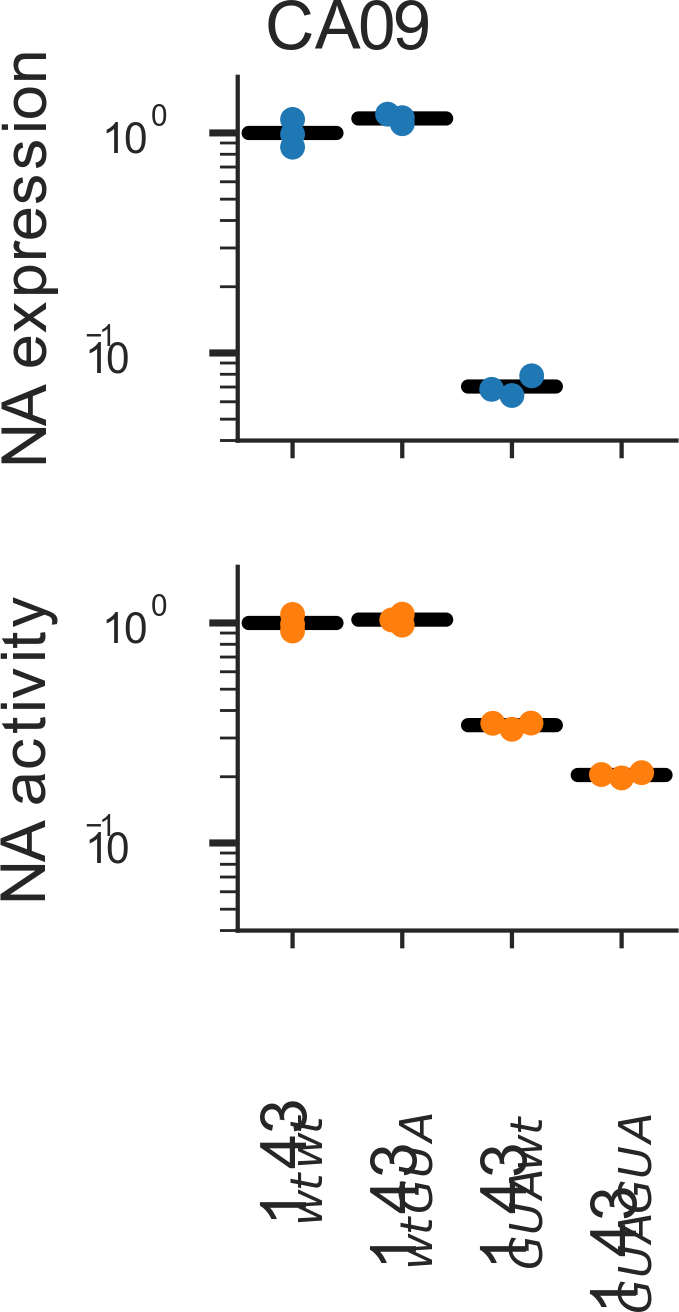

In [19]:
outfile='ca09_na_activity_expression'
plot_order = ["1ATG_43ATG","1ATG_43GTA","1GTA_43ATG","1GTA_43GTA"]
xticklabca09 = ["1$_{wt}$ 43$_{wt}$",r'1$_{wt}$ 43$_{GUA}$',r'1$_{GUA}$ 43$_{wt}$',r'1$_{GUA}$ 43$_{GUA}$']
strain='ca09'
fig_size=[1.5, 3.2]
file_dir='../data/'
aspect=1.2
size=1.4

wsnplot=plot_viral_strain(file_dir,outfile,plot_order,xticklabca09,concat_df,strain,fig_size,aspect,size)


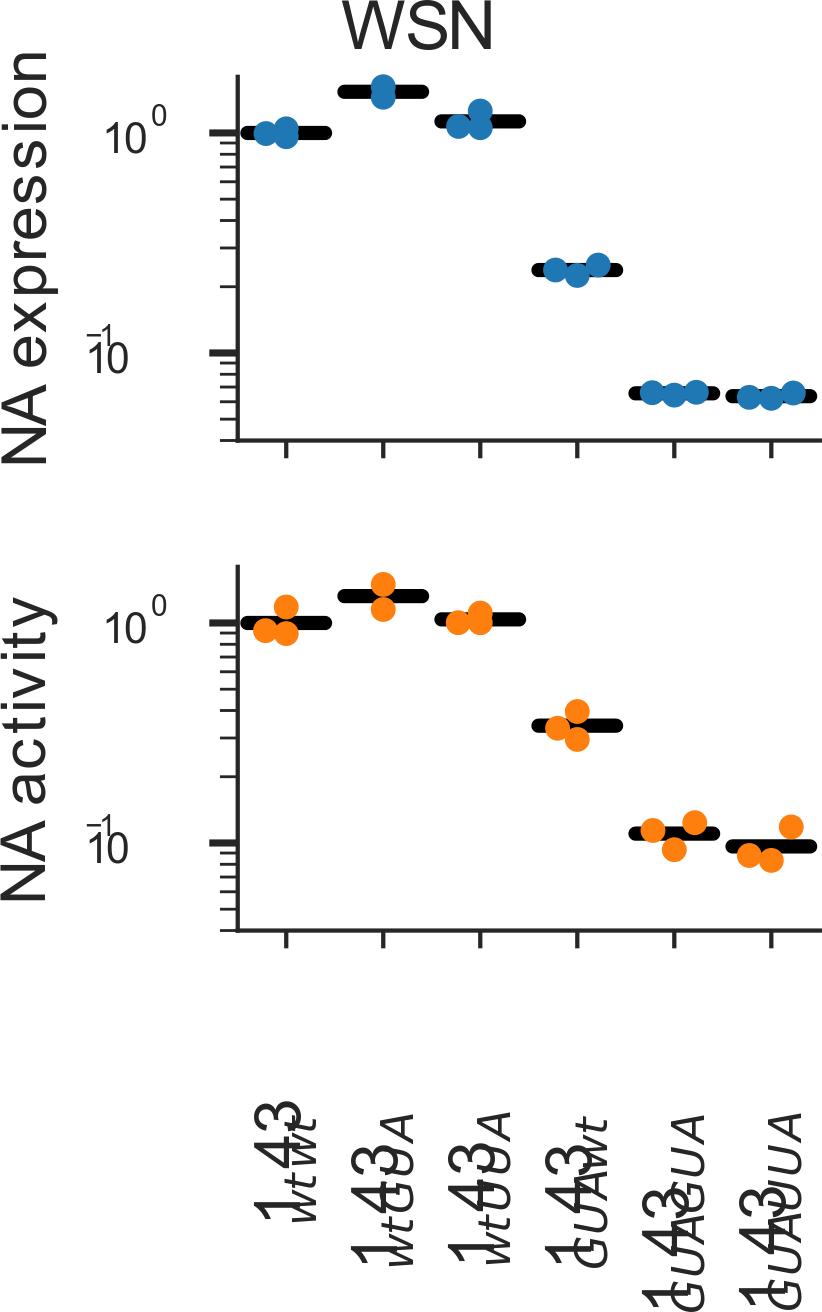

In [18]:
outfile='wsn_na_activity_expression'
plot_order = ["1ATG_43ATG","1ATG_43GTA","1ATG_43TTA","1GTA_43ATG","1GTA_43GTA","1GTA_43TTA"]
xticklabwsn = ["1$_{wt}$ 43$_{wt}$",r'1$_{wt}$ 43$_{GUA}$',r'1$_{wt}$ 43$_{UUA}$',r'1$_{GUA}$ 43$_{wt}$',r'1$_{GUA}$ 43$_{GUA}$',r'1$_{GUA}$ 43$_{UUA}$']
strain='wsn'
fig_size=[1.8, 3.2]
aspect=1.4
size=1.4

wsnplot=plot_viral_strain(file_dir,outfile,plot_order,xticklabwsn,concat_df,strain,fig_size,aspect,size)



## Plot ribo-seq and ribo-seq + LTM density around NA43 as stacked bar plot

In [16]:
flu_gtf_file = "../data/genomes/influenza/lowctgnp_wsn_pr8.gtf.tsv"

flu_gtf = pd.read_csv(
    flu_gtf_file, 
    sep='\t', 
    header=None,
    names=['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'])
NAname=np.nan  ## influenza na converted to NaN value 
flu_gtf = flu_gtf[flu_gtf['source'].notnull()]
flu_gtf=flu_gtf.fillna(value='NA')
Nstart=flu_gtf.query('seqid=="NA" & type == "start_codon"').start.values[0]  ### this is based on 1 numbering
NAstart=Nstart-1  #python numbering

18

/home/hmachkov/venv/hm_py2/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/hmachkov/venv/hm_py2/local/lib/python2.7/site-packages/matplotlib/legend.py:645: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


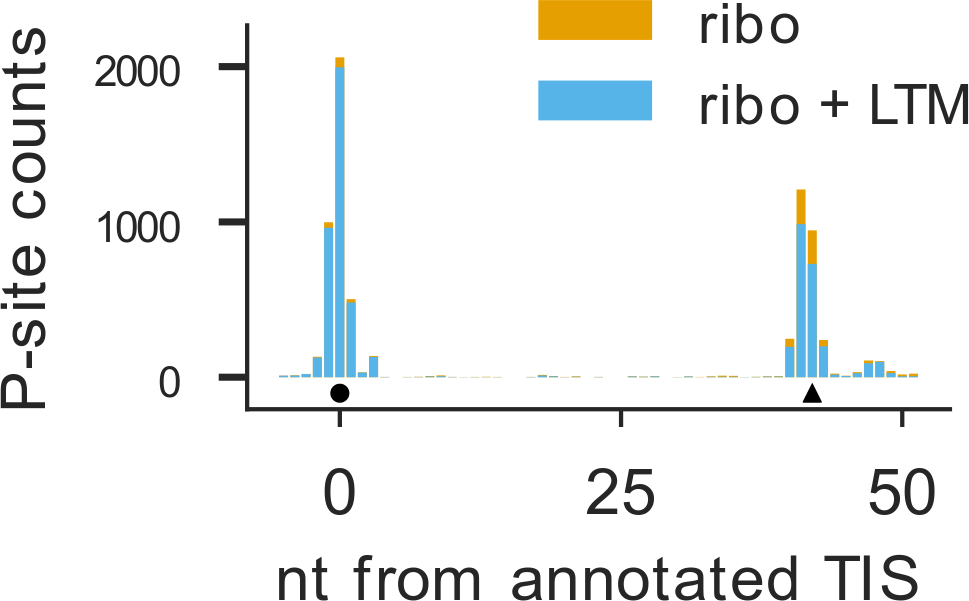

In [17]:
sample_coverage_dir='../data/riboseq/coverage/flu/'
samples=[['cyclo_vir','ltm_vir']]
title=['+vir','+ifn +vir']
filename=['vir','ifn_vir']
c=0
for samplepair in samples:
    i=0
    for sample in samplepair:
        #print sample
        cov = pd.read_csv('%s%s.flu.plus.genome.tsv.gz'%(sample_coverage_dir,sample), compression='gzip', header=0, sep='\t', quotechar='"')
        cov=cov.fillna(value='NA')
        NA=cov.query('seqname=="NA"')
        NA_coverage=[]
        NA['start']=NA['start']-1
        for index, row in NA.iterrows():
            length=row['end']-row['start']
            row_coverage=[row['score']] * length
            NA_coverage+=row_coverage
        if i==0:
            ribo=NA_coverage
        if i==1:
            ltm=NA_coverage
        i+=1
            
    fig, ax = matplotlib.pyplot.subplots()      
    stacked = [sum(x) for x in zip(ribo, ltm)]
    xval=[i  for i in range(0,(70-(NAstart-5)))]
    xvals=[i-5 for i in xval]
 
    ax.bar(xvals,stacked[NAstart-5:70], alpha = 1, label = 'ribo',color = '#E69F00')
    ax.bar(xvals,ltm[NAstart-5:70], alpha = 1, label = 'ribo + LTM',color = '#56B4E9')
    ax.scatter([42], [-.05*max(stacked[NAstart-5:70])],marker='^', color='black',s=6)   
    ax.scatter([0], [-.05*max(stacked[NAstart-5:70])],marker='o', color='black',s=6)    

    ax.set_xlabel('nt from annotated TIS')
    ax.set_ylabel('P-site counts')
 
    ax.set_ylim(-.1*max(stacked[NAstart-5:70]),max(stacked[NAstart-5:70])+max(stacked[NAstart-5:70])*.1)
    fig.legend(loc=0)

    sns.despine()
    fig.set_size_inches(2.1,1.4)

    fig.tight_layout(pad=1)
    filepath = '../figures/NA43_candidatestart%s.svg' %filename[c]
    plt.savefig(filepath)
    png = filepath.rstrip('.svg') + '.png'
    !convert -density 192 -trim $filepath $png
    display(Image(png, width=300))

    sys.stdout.flush()
    c+=1
